In [1]:
import csv
import glob
import math
import pandas as pd
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime
from obspy.geodetics import locations2degrees

class GeoPoint():
    def __init__(self, lon, lat, isRadian=False):
        # self.anomaly = anomaly if anomaly else None
        if isRadian:
            self._longitude = lon
            self._latitude = lat
        else:
            self._longitude = lon / 180 * math.pi
            self._latitude = lat / 180 * math.pi
        self._regulate_angle()
        self.longitude = {"rad": self._get_angle('lon', 'rad'), "deg": self._get_angle('lon', 'deg')}
        self.latitude = {"rad": self._get_angle('lat', 'rad'), "deg": self._get_angle('lat', 'deg')}

    def _get_angle(self, inp: str, oup: str = 'deg'):
        self._regulate_angle()

        if inp == "lon": quantity = self._longitude
        elif inp == "lat": quantity = self._latitude

        if oup == "rad": return float(quantity)
        elif oup == "deg": return quantity / math.pi * 180

    def _regulate_angle(self):
        "regulate longitude within [-pi,*pi) and latitude [-pi/2,*pi/2]"
        self._longitude = (self._longitude+math.pi)%(2*math.pi)-math.pi
        self._latitude = math.acos(math.cos(self._latitude+math.pi/2))-math.pi/2
            
    def midpoint(self, point1, point2):
        # const φ1 = lat1 * Math.PI/180; // φ, λ in radians
        # const φ2 = lat2 * Math.PI/180;
        # const Δφ = (lat2-lat1) * Math.PI/180;
        # const Δλ = (lon2-lon1) * Math.PI/180;
        # const Bx = Math.cos(φ2) * Math.cos(λ2-λ1);
        # const By = Math.cos(φ2) * Math.sin(λ2-λ1);
        # const φ3 = Math.atan2(Math.sin(φ1) + Math.sin(φ2),
        #                     Math.sqrt( (Math.cos(φ1)+Bx)*(Math.cos(φ1)+Bx) + By*By ) );
        # const λ3 = λ1 + Math.atan2(By, Math.cos(φ1) + Bx);
        dLon = point2._longitude - point1._longitude
        Bx = math.cos(point2._latitude) * math.cos(dLon)
        By = math.cos(point2._latitude) * math.sin(dLon)
        mlat = math.atan2(math.sin(point1._latitude) + math.sin(point2._latitude),
                        math.sqrt((math.cos(point1._latitude) + Bx) * (math.cos(point1._latitude) + Bx) + By * By))
        mlon = point1._longitude + math.atan2(By, math.cos(point1._latitude) + Bx)
        return GeoPoint(mlon, mlat, isRadian=True)

In [2]:
df = pd.read_csv('catalog_2011_preproc.csv')
result = df.loc[(df['source_origin_time'] == str(UTCDateTime("2011-01-05T06:46:18.300Z"))) & (df['receiver_code'] == 'ANMO')]

In [60]:
result = df.loc[(df['source_origin_time'] == timeref) & (df['receiver_code'] == 'RODM')]
# result = ref_table_slice.loc[(df['source_distance_deg'] == 94.522187)]

In [22]:
result['source_depth_km']

125.9

In [3]:
import pickle
from picker import SeismicData, Event, Station
from multiprocessing.pool import ThreadPool
class ResultPlot():
    def __init__(self, input_dir="/Users/jun/phasepick/hmsl_pred", pkl_table=None, csv_table=None):
        table_dir = "/Users/jun/Downloads/drive-download-20220512T014633Z-001"
        self.input_dir = input_dir
        if pkl_table:
            self.table_filenames = None
            with open(pkl_table, 'rb') as file:
                self.table = pickle.load(file)
        elif csv_table:
            self.table = pd.read_csv(csv_table)
            self.table_filenames = None
        else:
            self.table = None
            self.table_filenames = {"P": f"{table_dir}/Pcomb.4.07.09.table", "S": f"{table_dir}/Scomb.4.07.09.table"}

    def _midpoint(self, evlon, evlat, stlon, stlat):
        return GeoPoint.midpoint(_, GeoPoint(evlon, evlat), GeoPoint(stlon, stlat))

    def dumpall(self, phase, output):
        data = []
        model = TauPyModel(model="prem")
        with open(output, 'w') as outp:
            writer = csv.writer(outp)
            if self.table_filenames:
                table_org = pd.read_csv(self.table_filenames[phase], delim_whitespace=True) 
                table_alt = pd.read_csv(self.table_filenames['S' if phase=='P' else 'P'], delim_whitespace=True)
            else:
                table_org = None
                table_alt = None
            fileanames = glob.glob(f"{self.input_dir}/*_outputs/X_prediction_results.csv")
            writer.writerow(['file_name', 'turning_lon', 'turning_lat', 'gcarc' , 'anomaly', 'probability', 'anomaly_org'])
            for fileaname in fileanames:
                table_sta = pd.read_csv(fileaname)
                print(f"processing {fileaname}")
                for index, record in table_sta.iterrows():
                    if type(record[f'{phase.lower()}_arrival_time']) == str:
                        timestamp_rec = UTCDateTime(record['file_name'].split('_')[-1])
                        if self.table is None: # using HMSL tables as reference
                            try:
                                table_match = table_org[(table_org['station']==record['station'].rstrip()) & (table_org['year']==int(timestamp_rec.year)) & (table_org['day']==int(timestamp_rec.julday)) & (table_org['hour']==int(timestamp_rec.hour)) & (table_org['min']==int(timestamp_rec.minute)) & (abs(table_org['sec']-int(timestamp_rec.second))<2)].to_dict(orient='records')[0]
                                anomaly_org = table_match['obstim'] - table_match['calctim']
                                anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - table_match['calctim']
                                gcarc = locations2degrees(table_match['eqlat'], table_match['eqlon'], table_match['stalat'], table_match['stalon'])
                            except:
                                table_match = table_alt[(table_alt['station']==record['station'].rstrip()) & (table_alt['year']==int(timestamp_rec.year)) & (table_alt['day']==int(timestamp_rec.julday)) & (table_alt['hour']==int(timestamp_rec.hour)) & (table_alt['min']==int(timestamp_rec.minute)) & (abs(table_alt['sec']-int(timestamp_rec.second))<2)].to_dict(orient='records')[0]
                                anomaly_org = None
                                gcarc = locations2degrees(table_match['eqlat'], table_match['eqlon'], table_match['stalat'], table_match['stalon'])
                                calctim = model.get_travel_times(table_match['eqdep'], gcarc, [phase])
                                if len(calctim) > 0:
                                    anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - calctim[0].time
                            eqlon = table_match['eqlon']
                            eqlat = table_match['eqlat']
                        else:
                            if type(self.table) == pd.DataFrame:
                                records_found = self.table.loc[(self.table['source_origin_time'] == str(timestamp_rec)) & (self.table['receiver_code'] == record['station'].rstrip())]
                                if len(records_found) == 0: continue # ignore the predictions coming from waveform files that failed sanity check as training data
                                record_match = records_found.iloc[0]
                                gcarc = record_match['source_distance_deg']
                                calctim = model.get_travel_times(record_match['source_depth_km'], gcarc, [phase])
                                eqlon = record_match['source_longitude']
                                eqlat = record_match['source_latitude']
                                anomaly_org = None
                                if len(calctim) > 0:
                                    anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - calctim[0].time
                                else: continue

                            else: 
                                # using event-pair information from pickle file
                                event_match = None
                                station_match = None
                                anomaly_org = None
                                for event in self.table.events:
                                    if event.srctime == timestamp_rec: event_match = event; break
                                for station in event_match.stations:
                                    if station.labelsta['name'] == record['station'].rstrip(): station_match = station; break
                                if station_match is None: continue

                                gcarc = station_match.labelsta['dist']
                                calctim = model.get_travel_times(event_match.srcloc[2], gcarc, [phase])
                                eqlon = event_match.srcloc[1]
                                eqlat = event_match.srcloc[0]
                                if len(calctim) > 0:
                                    anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - calctim[0].time
                                else: continue

                        if abs(anomaly) < 20:
                            point = self._midpoint(eqlon, eqlat, record['station_lon'], record['station_lat'])
                            # writer.writerow([record['file_name'],'%.3f'%point.longitude['deg'], '%.3f'%point.latitude['deg'], '%.4f'%gcarc, '%.4f'%anomaly, record[f'{phase.lower()}_probability'], '%.4f'%anomaly_org if anomaly_org else None])
                            data.append([record['file_name'],'%.3f'%point.longitude['deg'], '%.3f'%point.latitude['deg'], '%.4f'%gcarc, '%.4f'%anomaly, record[f'{phase.lower()}_probability'], '%.4f'%anomaly_org if anomaly_org else None])


            writer.writerows(data)

In [101]:
start_year = 2012
num_years = 2

folder_prefix_list = [f"catalog_{start_year+year}_stnflt" for year in range(num_years)]
for folder_prefix in folder_prefix_list:
    folder_name =  f"{folder_prefix}_hdfs"
    plot = ResultPlot(input_dir=f"./updeANMO_shift5_pred_{folder_prefix}", csv_table=f'./{folder_prefix[:12]}_preproc.csv')
    plot.dumpall('P', f'./updeANMO_shift5_{folder_prefix}_plot_p.csv')
    plot.dumpall('S', f'./updeANMO_shift5_{folder_prefix}_plot_s.csv')

processing ./updeANMO_shift5_pred_catalog_2012_stnflt/UPI_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/RODM_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/RAYN_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/KONO_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/ADK_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/VLC_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/WAKE_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/ROCAM_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/HRV_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/HIZ_outputs/X_prediction_results.csv
processing ./updeANMO_shift5_pred_catalog_2012_stnflt/FUNA_outputs/X_prediction_resu

In [77]:
plot = ResultPlot(input_dir="updeANMO_shift5_pred_catalog3", pkl_table='./rawdata_catalog3/data_fetched_catalog_2010_3.pkl')
plot.dumpall('P', './updeANMO_shift5_catalog_2010_stnflt_plot_p.csv')
plot.dumpall('S', './updeANMO_shift5_catalog_2010_stnflt_plot_s.csv')

processing updeANMO_shift5_pred_catalog3/SM48_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/MMNY_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/C16W_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/SM58_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/KZA_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/C17W_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/UPI_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/L04D_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/ISLE_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/AD15_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/AD05_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/B202_outputs/X_prediction_results.csv
processing updeANMO_shift5_pred_catalog3/BH5G_outputs/

14919 points fit the conditions
18322 points fit the conditions


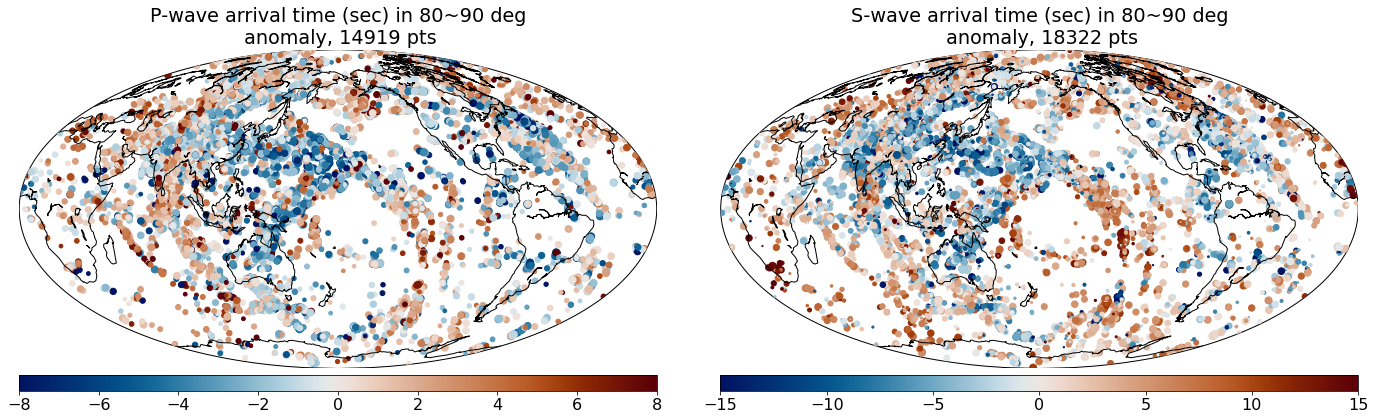

In [13]:
import glob
import numpy as np
import pandas as pd
from cmcrameri import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
plt.rcParams["font.size"] = 16
# plt.style.use('dark_background')
# map = Basemap(projection='ortho', 
#               lat_0=0, lon_0=0)
map = Basemap(projection='moll',lon_0=-180,resolution='c')
map.drawmapboundary(fill_color='white')
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')

def fidelity_rev(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.1#0.72
def fidelity_rev_p(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.5#0.75

def plot_depthslice(phase: str, value: str, gcarc_range: set, fidelity_func, org_constraint=lambda tb: pd.isnull(tb) | pd.notnull(tb), raw_prefix='updeANMO_shift_plot', ref_prefix='updeANMO_plot', mark_size=lambda r: 50*r**2):
    # table = pd.read_csv('test_plot_p.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] >85)]
    # table = pd.read_csv('test_plot_s.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.8) & (table['gcarc'] > 85)]
    # alpha = 0.75
    table_raw = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'{raw_prefix}_{phase.lower()}.csv')], ignore_index=True)
    table_ref = pd.read_csv(f'{ref_prefix}_{phase.lower()}.csv')
    columns_joined = pd.DataFrame({'file_name': table_ref['file_name'].values, 'probability_ref': table_ref['probability'].values, 'anomaly_ref': table_ref['anomaly'].values})
    table = table_raw.merge(columns_joined, how='left', on='file_name')
    fidelity = fidelity_func(picker1_prob=table['probability'],
                             picker1_anomaly=table['anomaly'],
                             picker2_prob=table['probability_ref'],
                             picker2_anomaly=table['anomaly_ref'])
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['probability_ref'] > 0.7)  & (abs(table['anomaly']-table['anomaly_ref']) < 5) & (table['gcarc'] > 80)]
    # scatter_table = table[(table['probability'] > 0.7) & (table['gcarc'] < 95) & (table['gcarc'] > 85)] ##p
    if value=='anomaly_org': fidelity = (fidelity+1)
    scatter_table = table[(org_constraint(table['anomaly_org'])) & (fidelity > 0) & (table['gcarc'] > gcarc_range[0]) & (table['gcarc'] < gcarc_range[1])]
    # fidelity = table['probability'] - alpha*(abs(table['anomaly']-table['anomaly_ref']))/table['anomaly'].std()*table['probability_ref']
    # scatter_table = table[(table['anomaly_org'].isnull()) & (fidelity > 0) & (table['gcarc'] > 80)]
    # table = pd.read_csv(f'test_plot_{phase.lower()}.csv')
    # table = pd.read_csv(f'updeANMO_shift_plot_{phase.lower()}.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] > 80)]

    lons = scatter_table['turning_lon'].values[:]
    lats = scatter_table['turning_lat'].values[:]
    prob = scatter_table['probability'].values[:]
    anomaly = scatter_table[value].values[:]
    print(f"{sum(scatter_table[value].notnull())} points fit the conditions")
    # print(type(anomaly[0]))

    x, y = map(lons, lats)
    anomaly -= np.nanmean(anomaly)

    map.drawmapboundary(fill_color='white')
    map.drawcoastlines()
    map.scatter(x, y, c=anomaly, s=mark_size(prob), marker='o', cmap=cm.vik)
    # map.scatter(x, y, c=anomaly, marker='o', cmap=cm.vik)
    map.colorbar(location='bottom')
    colorscale = 15 if phase.lower() == 's' else 8
    plt.clim(-colorscale, colorscale)
    plt.title(f'{phase.upper()}-wave arrival time (sec) in {gcarc_range[0]}~{gcarc_range[1]} deg\n {value}, {sum(scatter_table[value].notnull())} pts')

top_gcarc = 80
gcarc_interval = 10

plt.subplot(121)
plot_depthslice('p', 'anomaly', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev_p, raw_prefix='updeANMO_shift5_catalog_*_stnflt_plot')
plt.subplot(122)
plot_depthslice('s', 'anomaly', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev, raw_prefix='updeANMO_shift5_catalog_*_stnflt_plot')
# plot_depthslice('s', 'anomaly', (90,110), fidelity_rev, raw_prefix='updeANMO_shift5_catalog_plot')
plt.subplots_adjust(wspace=0.1)
plt.show()

In [33]:
raw_prefix = "updeANMO_shift5_catalog_*_stnflt_plot"
phase = "p"
df = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'{raw_prefix}_{phase.lower()}.csv')], ignore_index=True)
df

,file_name,turning_lon,turning_lat,gcarc,anomaly,probability,anomaly_org
0,RODM_G_LH_2011-01-09T10:03:53.600Z,115.899,-30.027,96.5814,-2.50,0.22,NaN
1,RODM_G_LH_2011-01-09T17:21:57.700Z,115.874,-30.103,96.5374,4.50,0.38,NaN
2,RODM_G_LH_2011-07-26T14:26:28.000Z,65.324,-14.455,11.0823,6.75,0.76,NaN
3,RODM_G_LH_2011-12-11T09:54:59.800Z,32.398,-47.057,74.4497,1.00,0.94,NaN
4,RODM_G_LH_2011-06-13T14:31:26.100Z,95.932,-9.910,65.6592,5.75,0.70,NaN
...,...,...,...,...,...,...,...
117745,ZKR_GE_LH_2012-08-12T10:47:12.000Z,54.222,38.970,45.1834,3.50,0.80,NaN
117746,ZKR_GE_LH_2012-03-17T17:00:57.800Z,46.717,20.395,46.5478,7.75,0.17,NaN
117747,ZKR_GE_LH_2012-12-13T23:03:38.000Z,37.329,62.337,56.2029,-0.25,0.26,NaN
117748,ZKR_GE_LH_2012-06-09T21:00:19.300Z,77.595,40.503,80.7493,4.00,0.89,NaN


In [49]:
import os
import pandas as pd
from obspy import read_inventory, UTCDateTime

station_dict = {}
event_list = []
for idx, val in df['file_name'].items():
    file_name_splits = val.split('_')
    key = f'{file_name_splits[1]}.{file_name_splits[0]}'
    if not key in station_dict: station_dict[key] = file_name_splits[-1]
    if not file_name_splits[-1] in event_list: event_list.append(file_name_splits[-1])

st_lons = []
st_lats = []
df_year = None
for key, event in station_dict.items():
    if event[:4]=='2010': continue
    if df_year != event[:4]:
        df_ref = pd.read_csv(f"./catalog_{event[:4]}_preproc.csv")
        df_year = event[:4]
    found = df_ref.loc[df_ref['receiver_code'] == key.split('.')[-1]].iloc[0]
    st_lons.append(found['receiver_longitude'])
    st_lats.append(found['receiver_latitude'])

ev_lons = []
ev_lats = []
df_year = None
for event in event_list:
    if event[:4]=='2010': continue
    if df_year != event[:4]:
        df_ref = pd.read_csv(f"./catalog_{event[:4]}_preproc.csv")
        df_year = event[:4]
    found = df_ref.loc[df_ref['source_origin_time'] == str(UTCDateTime(event, precision=6))].iloc[0]
    ev_lons.append(found['source_longitude'])
    ev_lats.append(found['source_latitude'])

In [37]:
df_ref = pd.read_csv(f"./catalog_{event[:4]}_preproc.csv")
df_ref['source_origin_time']

0        2011-03-12T12:53:52.700000Z
1        2011-03-12T12:53:52.700000Z
2        2011-03-12T12:53:52.700000Z
3        2011-03-12T12:53:52.700000Z
4        2011-03-12T12:53:52.700000Z
                    ...             
98444    2011-10-28T18:54:43.100000Z
98445    2011-10-28T18:54:43.100000Z
98446    2011-10-28T18:54:43.100000Z
98447    2011-10-28T18:54:43.100000Z
98448    2011-10-28T18:54:43.100000Z
Name: source_origin_time, Length: 98449, dtype: object

In [ ]:
ev_lons

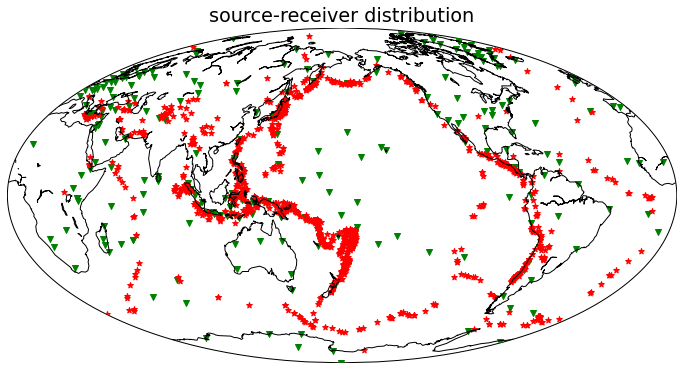

In [53]:
import glob
import numpy as np
import pandas as pd
from cmcrameri import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 16
map = Basemap(projection='moll',lon_0=-180,resolution='c')
# map.drawmapboundary(fill_color='white')

def plot_source_receiver(raw_prefix='updeANMO_shift_plot'):
    table_raw = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'{raw_prefix}_{phase.lower()}.csv')], ignore_index=True)
    
    station_dict = {}
    event_list = []
    for idx, val in df['file_name'].items():
        file_name_splits = val.split('_')
        key = f'{file_name_splits[1]}.{file_name_splits[0]}'
        if not key in station_dict: station_dict[key] = file_name_splits[-1]
        if not file_name_splits[-1] in event_list: event_list.append(file_name_splits[-1])

    st_lons = []
    st_lats = []
    df_year = None
    for key, event in station_dict.items():
        if event[:4]=='2010': continue
        if df_year != event[:4]:
            df_ref = pd.read_csv(f"./catalog_{event[:4]}_preproc.csv")
            df_year = event[:4]
        found = df_ref.loc[df_ref['receiver_code'] == key.split('.')[-1]].iloc[0]
        st_lons.append(found['receiver_longitude'])
        st_lats.append(found['receiver_latitude'])

    ev_lons = []
    ev_lats = []
    df_year = None
    for event in event_list:
        if event[:4]=='2010': continue
        if df_year != event[:4]:
            df_ref = pd.read_csv(f"./catalog_{event[:4]}_preproc.csv")
            df_year = event[:4]
        found = df_ref.loc[df_ref['source_origin_time'] == str(UTCDateTime(event, precision=6))].iloc[0]
        ev_lons.append(found['source_longitude'])
        ev_lats.append(found['source_latitude'])

    map.drawmapboundary(fill_color='white')
    map.drawcoastlines()

    x, y = map(st_lons, st_lats)
    map.scatter(x, y, c='g', marker='v')
    x, y = map(ev_lons, ev_lats)
    map.scatter(x, y, c='r', marker='*')
    # map.scatter(x, y, c=anomaly, marker='o', cmap=cm.vik)
    plt.title(f'source-receiver distribution')

plot_source_receiver(raw_prefix='updeANMO_shift5_catalog_*_stnflt_plot')
plt.show()